# COM2004/COM3004 - Bayesian Classification

*Copyright &copy; 2023 University of Sheffield. All rights reserved*.

## Objectives

* To gain practical experience of Bayesian classification.
* To see how a classifier can be evaluated using separate training and test sets.
* To compare the performance of 'diagonal covariance’ and 'full covariance’ multivariate Gaussian models.
* To learn how to perform 'leave-one-out’ testing.

## 1. Background

So far, we have covered the theory of Bayesian classification and we have looked at trivial 1-dimensional and 2-dimensional examples. In this notebook we are going to use the same techniques but apply them to a genuine 13-dimensional classification problem – wine classification!

For each section, first read the instructions carefully and make sure that you understand what is being asked before typing any Python code. You will need to make use of the numpy and scipy python libraries (https://www.scipy.org/ and http://www.numpy.org/). If you are not sure how to do something try looking it up in the online documention. If you get stuck then ask a lab demonstrator for help.

## 2. Introduction

The data you will be using are the genuine results of chemical analyses of wines grown in the same region of Italy but produced from three different varieties of grape. The analyses have determined the quantities of 13 chemical constituents. The task is to use the results of the chemical analyses to identify which of the three grapes was used to produce an unlabeled bottle of wine.

## 3. Obtaining the data

The data will form a matrix with 178 rows and 14 columns. Each row is a separate sample (i.e., a different botttle of wine). The first column stores a class label (1, 2 or 3) representing the grape variety. Columns 2 to 14 are the results of the 13 chemical analyses. Note that the features are stored as columns and the samples as rows.

We will first load the data into a numpy array using the nump `loadtxt` function that we have seen in previous lab classes.

In [43]:
import numpy as np
X = np.loadtxt(open("data/wines.txt", "r"), delimiter=',')
X.shape

(178, 14)

We will also import `matplotlib` for use later in the notebook,

In [44]:
import matplotlib.pyplot as plt

## 4. Notes: Training and evaluating a classifier.

Using a classifier involves two stages. First, the classifier is trained using samples for which we know the correct class labels. Training is the process of estimating the classifier’s parameters, e.g., the means and variances of the data for each class, $\omega_i$, and the class priors, $P(\omega_i)$. Once the classifier is trained we can use it to label unknown data. Generally, however, before using the classifier, we first want to evaluate it, i.e., test it.

To *test* the classifier we will use a sample of data that was not seen during training, but for which we know the correct labels. We will classify each of the test samples and compare the classifier’s output to the *known correct* label. We then measure the percentage of the data that has been classified correctly and hope to get as close to 100% as possible. We may also want to look at the samples that are classified incorrectly to see if there is any pattern to the errors (e.g., perhaps two classes are often confused).

For reasons that will become clearer later in the module, it is very important that the data used for testing the classifier are not the same data that have been used for training it. So we usually start by partitioning our data into  separate (non-overlapping) training and test sets.

## 5. Preparing the wine data

We are going to prepare the data by first separating out the samples for each of the three classes, and then we will divide the data for each class equally between training and testing sets.

To find samples belonging to class 1 we need to select the rows of the matrix for which the first column contains a 1. If the data was stored in a numpy 2-D array, `X`, we could select these rows as follows

    X[X[:,0]==1,:]

Use this idea to separate the data into three numpy 2-D arrays that we will call `wines1`, `wines2` and `wines3`.

We want to split `wines1`, `wines2` and `wines3` into equal training and testing partitions. The easiest way is to put the odd rows in the training set and the even rows in the test set. The odd rows of an array `X` can be selected using the syntax 0::2 which iterates from 0 to the last index of a matrix in steps of 2, i.e

    X[0::2, :]

and for the even rows it would be

    X[1::2, :]
    
Use this idea to make matrices called `wines1_train`, `wines1_test`, `wines2_train` etc.

Finally, combine the test data for each class back into a single test data matrix by stacking the three test data matrices on top of each other. This can be done using numpy's `vstack` function,
    
    wines_test= np.vstack((wines1_test, wines2_test, wines3_test))

(Note the double braces above).

Put this all together in the cell below.

In [45]:
# Write your solution here 
wines1 = X[X[:,0]==1,:]
wines2 = X[X[:,0]==2,:]
wines3 = X[X[:,0]==3,:]

wines1_test = wines1[0::2,:]
wines1_train = wines1[1::2,:]

wines2_test = wines2[0::2,:]
wines2_train = wines2[1::2,:]

wines3_test = wines3[0::2,:]
wines3_train = wines3[1::2,:]

wines_train = np.vstack((wines1_train,wines2_train,wines3_train))
wines_test = np.vstack((wines1_test,wines2_test,wines3_test))
wines_test.shape


(90, 14)

## 6. Training the classifier

We are going to use a multivariate Gaussian distribution to represent the distribution of each of the three classes, $p(x|\omega)$ for $\omega$ equals 1, 2 or 3. So we need to estimate the mean vector and covariance matrix for each class. In the first instance we are going to assume that the features are uncorrelated. This means that the Gaussian covariance matrix will have 0s for all elements off the diagonal. This is no doubt a poor assumption but in means that our 13 by 13 covariance matrix only contains 13 variances that need estimating rather than 91 parameters (why 91 not 13x13?). Note, diagonal covariance matrices make the probability evaluations very quick to compute and are often used in classification systems, and they can work well even if they do not model the data exactly.

We can estimate the 13-element mean vector for each class using numpy's `mean` function. Note, you should only use columns 2 to 14 – remember, column 1 stores the class label. (Refer to the previous notebook if you have forgotten how to use `np.mean` to compute the means of each column of a matrix.) Store the results in variables called `mean1`, `mean2` and `mean3`, i.e., a separate mean vector for each class of wine.

We can estimate the variances (i.e., the elements along the diagonal of the covariance matrix) using the `np.var` function. Store the results in vectors called `var1`, `var2`, and `var3`.

In [46]:
# Write your solution here 
mean1 = np.mean(wines1_train[:,1:] , axis=0)
mean2 = np.mean(wines2_train[:,1:] ,axis=0 )
mean3 = np.mean(wines3_train[:,1:] , axis=0)
var1 = np.var(wines1_train[:,1:] , axis=0)
var2 = np.var(wines2_train[:,1:] , axis=0)
var3 = np.var(wines3_train[:,1:] , axis=0)

## 7. Evaluating the classifier

Once you have estimated means and variances for each class, the training stage is complete. You now need to use your classifier to process the test data and to compare the classifier outputs with the known test data labels.

To perform an actual classification we need to compute $p(x|\omega_1).P(\omega_1)$, $p(x|\omega_2).P(\omega_2)$ and $p(x|\omega_3).P(\omega_3)$ and see which gives the highest score. We will assume that the prior probabilities are equal, i.e., $P(\omega_1) = P(\omega_2) = P(\omega_3) = \frac{1}{3}$. We can therefore perform classification simply by comparing $p(x|\omega_1)$, $p(x|\omega_2)$ and $p(x|\omega_3)$.

To evaluate the multivariate Gassian pdf $p(x|\omega)$ for some known $x$ we can use the python function `multivariate_normal`. This is part of the Python `scipy.stats` module. To use it we first import it using
    
    from scipy.stats import multivariate_normal
    
We then construct a distribution object, `dist1`, with our chosen values for the mean and covariance parameters

    dist1 = multivariate_normal(mean=mean1, cov=np.diag(var1))
    
In the above example we have constructed the covariance matrix to be a diagonal matrix with the values in the vector `var1` along the diagonal (i.e., the variances that we estimated during the training stage). 

Finally, to evalute the distribution for a given value of the feature vector $x$ you use,

    p1 = dist1.pdf(x)
    
In the line above, $x$ can be a single feature vector, or a whole series of feature vectors stored in the rows of the data matrix, e.g., to evalutate the pdf for every wine sample in the test data,

    p1 = dist1.pdf(wines_test[:, 1:])

So now we are going to perform these evaluations for each of the three classes, i.e., using `mean1`, `var1`; then `mean2`, `var2` and finally, `mean3`, `var3`. To give us arrays of probabilities `p1`, `p2` and `p3`.

The three arrays `p1`, `p2` and `p3` will each have as many elements as there are samples in the test data, say $n$. 

Then, using `np.vstack` we will now form these outputs, `p1`, `p2` and `p3` into a single matrix, `p`, with $n$ columns and 3 rows, i.e. `p1` in the first row, `p2` in the second and `p3` in the third. i.e.,

    p = np.vstack((p1, p2, p3))
    
Put all of this together in the cell below

In [47]:
# Write your solution here 
from scipy.stats import multivariate_normal
dist1 = multivariate_normal(mean = mean1 , cov = np.diag(var1))
dist2 = multivariate_normal(mean = mean2 , cov = np.diag(var2))
dist3 = multivariate_normal(mean = mean3 , cov = np.diag(var3))
p1 = dist1.pdf(wines_test[:,1:])
p2 = dist2.pdf(wines_test[:,1:])
p3 = dist3.pdf(wines_test[:,1:])

p = np.vstack((p1,p2,p3))
# print(np.concatenate(([p1],[p2],[p3]),axis=0).shape)
print(p.shape)




(3, 90)


What do you observe about the output? Can you spot the classification errors?

We now need to compare the class labels that the classifier has output (`labels`) with the true labels that are stored in the first column of `wines_test`. We will then count how many labels match the true labels and divide by the total number of samples in the test set. Finally multiply by 100 get the result in terms of 'percentage correct'.

What percentage would you expect to classify correctly if you had just guessed the label? Is your classifier doing better than this?

In [56]:
# Write your solution here
correctNum =  np.sum(wines_test[:,0] == w )
incorrectNum = np.sum(wines_test[:,0] != w)
correctRate = correctNum/(incorrectNum + correctNum)
print( f'The correct rate is {correctRate * 100} %' )



The correct rate is 97.77777777777777 %


## 8. Improving the statistical model

Our diagonal covariance model was quick to compute and to evaluate but it is a poor model of the true distribution of the data. Some of the features are quite highly correlated. We will now repeat the process but this time using a full covariance model. This only requires a minor change to the previous code, so we should be able to put it together quickly by cutting and pasting from previous code cells.

Rather than estimate a vector of variances using `np.var`, you can now estimate the full 13x13 covariance matrix using the `np.cov` function, i.e., to estimate the covariance matrix for `wines1_train` data,

    cov1 = np.cov(wines1_train[:, 1:], rowvar=0)

Estimate the covariance matrix for each of `wines1_train`, `wines2_train` and `wines3_train`, storing the results in `cov1`, `cov2` and `cov3`.

Testing is just the same as before but now you simply pass `cov1`, `cov2` and `cov3` as the final parameter of function `multivariate_normal` instead of `var1`, `var2` and `var3`.

Repeat the multivariate normal evaluations and compute a new `p` array. Use `argmax` again to get the output labels. Score the new labels by matching against the correct test set labels.

Put the code together in the cell below. Has performance improved?

(90,) (90,) (90,)
(270,)
(3, 90)
The correct rate is 98.88888888888889 %


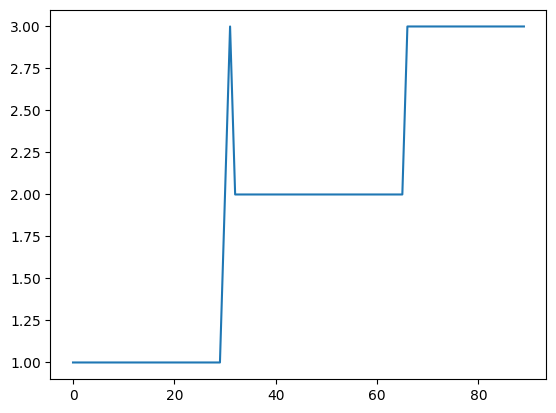

In [65]:
# Write your solution here 

cov1 = np.cov(wines1_train[:,1:] , rowvar = 0)
cov2 = np.cov(wines2_train[:,1:] , rowvar = 0)
cov3 = np.cov(wines3_train[:,1:] , rowvar = 0)


dist1 = multivariate_normal(mean = mean1 , cov = cov1)
dist2 = multivariate_normal(mean = mean2 , cov = cov2)
dist3 = multivariate_normal(mean = mean3 , cov = cov3)
p1 = dist1.pdf(wines_test[:,1:])
p2 = dist2.pdf(wines_test[:,1:])
p3 = dist3.pdf(wines_test[:,1:])
print(p1.shape,p2.shape,p3.shape)
p = np.vstack((p1,p2,p3))
print(np.concatenate(([p1],[p2],[p3]),axis=0).shape)
print(p.shape)

w = np.argmax(p, axis=0) + 1
plt.plot(w)

correctNum =  np.sum(wines_test[:,0] == w )
incorrectNum = np.sum(wines_test[:,0] != w)
correctRate = correctNum/(incorrectNum + correctNum)
print( f'The correct rate is {correctRate * 100} %' )

## 9. More accurate evaluation

The problem with this task is that after splitting the data into training and test sets there is barely sufficient data to accurately estimate the classifier parameters (remember, from Lab 2, that sample means and variances estimates have a good chance of being inaccurate when $N$ is small). Also there is not really enough data for accurately evaluating the classifier: just 1 extra error changes the performance evaluation by more than 1%.

Ideally we want to be able to use all the data for training and all the data for testing – but it was said earlier that we need to keep training and testing data separate, i.e., testing on data that has been used during training does not produce valid results. 

So what is the solution? How can we use all the data for training, all the data for testing *and* having training and test sets that do not overlap?

The solution is to do something called ‘leave-one-out’ testing. In this approach we use just the first sample for testing and train using all the remaining $N-1$ samples. But then we repeat the exercise using the 2nd sample for testing and the other $N-1$ for training, and then again using the 3rd sample for testing and so on until we have tested all $N$ samples. We can then report the combined result of all $N$ tests.

The obvious downside to this is that we now have to train $N$ different classifiers, i.e. each classifier is trained using the full set of data but with a different test sample omitted. However computers are good at doing repetitive things, so for small problems leave-one-out testing is a practical approach.

By using a loop we can iterate through the data samples and call a function that tests a single target sample while training on the remaining $N-1$ samples. The code is below but you need to complete the fuction `test_one_out`.

Complete the code below and use it to re-evaluate the classifier using both the diagonal and full-covariance models. 

What are your new results and how do they compare to those you had earlier?

In [84]:
def test_one_out(data, test_index):
    # This function should train a classifier using all the data in
    # 'data' except the sample test_index. It should then test the
    # sample test_index. And return True if the sample is classified
    # correctly or else return False
    # COMPLETE THE CODE
    #
    #
    # print(data.shape)
    test_data = data[test_index,:]
    # print(test_data.shape)
    train_data = np.concatenate((data[:test_index],data[test_index+1:,]))
    # print(train_data.shape)
    train1 = train_data[train_data[:,0]==1]
    train2 = train_data[train_data[:,0]==2]
    train3 = train_data[train_data[:,0]==3]

    mean1 = np.mean(train1[:,1:] , axis=0)
    mean2 = np.mean(train2[:,1:] , axis=0)
    mean3 = np.mean(train3[:,1:] , axis=0)

    cov1 = np.cov(train1[:,1:] , rowvar= 0 )
    cov2 = np.cov(train2[:,1:] , rowvar= 0 )
    cov3 = np.cov(train3[:,1:] , rowvar= 0 )

    dist1 = multivariate_normal(mean = mean1, cov = cov1)
    dist2 = multivariate_normal(mean = mean2, cov = cov2)
    dist3 = multivariate_normal(mean = mean3, cov = cov3)

    p1 = dist1.pdf(test_data[1:])
    p2 = dist2.pdf(test_data[1:])
    p3 = dist3.pdf(test_data[1:])
    
    p = np.concatenate(([p1],[p2],[p3]),axis = 0 )

    index = np.argmax(p) + 1
    correct = index == data[test_index, 0]
  
    return correct

def classify(data):
    """Classify every sample using leave-one-out training"""
    ncorrect = 0
    ntotal = data.shape[0]
    for index in range(ntotal):
        ncorrect = ncorrect + test_one_out(data, index)
    percent_correct = ncorrect * 100.0 / ntotal
    return percent_correct
    
print(classify(X))

99.43820224719101


## 10. Selecting features

Say that you were told that the current wine classification system was too expensive to run. Performing 13 separate chemical analyses is taking too long and the chemists want to reduce the number of tests down to 6. Which 6 features would you choose to ensure best performance?

Notice that the code you have written is equally valid for tasks of any dimensionality, ie., the constant 13 should not have to appear anywhere in the code. So you could evaluate a 6-D version of the classifier simply by selecting the label column and 6 additional columns as the very first step of the program, e.g.,
    
    wines6D = wines[:, [0, 1, 4, 6, 8, 9, 12]]

In [85]:
# e.g. feature 1, 4, 6, 8, 9, 12 will allow a performance of 93.8%
wines6D = X[:, [0, 1, 4, 6, 8, 9, 12]]
print(wines6D.shape)
print(classify(wines6D))

(178, 7)
93.82022471910112


In [86]:
# Try experimenting with different choices of features here.
wines5D = X[:, [0, 1, 3, 7, 11, 13]]
print(wines5D.shape)
print(classify(wines5D))

(178, 6)
99.43820224719101


**Challenge**: Can you find 6 features that perform almost as well as the full 13?

In the 2nd half of the module we will be looking at some techniques for solving this problem but for now either use trial and error or try looking at the histograms of individual features to find dimensions along which the classes appear to be well separated.

In [95]:
max_corr = 0
max_feature = []

for i in range (1000):
    features = np.sort( np.random.choice(range(1, 13), 6, replace=False))
    wines6Feature = X[:, [0,*features]]
    if classify(wines6Feature) > max_corr : 
        max_corr = classify(wines6Feature)
        max_feature = features

print(f'The best feature is {max_feature}, and correct rate is {max_corr}')

     

The best feature is [ 1  3  4  5  7 11], and correct rate is 99.43820224719101
